In [ ]:
%cd /content/drive/MyDrive/Doutorado/Séries\ Temporais/Trabalho_Fuzzy
!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install -U SimpSOM
!pip install "git+https://github.com/tqdm/tqdm.git@devel#egg=tqdm"

In [11]:
import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from pyFTS.common import Util

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Reading Data

In [12]:
# reading data
c2g_data = pd.read_csv('timeseries-forecast/data/demand_datasets/c2g_demand.csv', index_col=0)

#cleaning process
c2g_data.index = pd.to_datetime(c2g_data.index)

init_period = '2016-12-13 15:00'
end_period = '2017-02-25 17:00'

c2g_data = c2g_data[(c2g_data.index >= init_period) & (c2g_data.index <= end_period)]

# shift the dataset in 24 hours to split the data equals to the time shift models
c2g_data = c2g_data.iloc[24:]

## Split in Training and Test

In [13]:
# splitting in train (80%) and test data (20%)
def split(data, perc=0.8):
    index = int(len(data)*0.8)
    return data[:index], data[index:]

c2g_train, c2g_test = split(c2g_data)

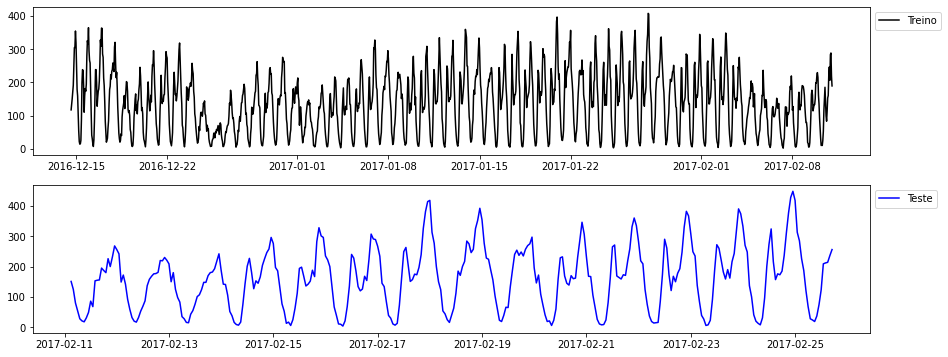

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,6])  
ax[0].plot(c2g_train.travels, label='Treino',color='black')
handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

ax[1].plot(c2g_test.travels, label='Teste',color='blue')
handles, labels = ax[1].get_legend_handles_labels()
lgd = ax[1].legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

## Filter

In [15]:
c2g_train_new = pd.DataFrame()
c2g_train_new['data'] = c2g_train.index
c2g_train_new['data'] = pd.to_datetime(c2g_train_new["data"], format='%Y-%m-%d %H:%M:%S')
c2g_train_new['travels'] = c2g_train['travels'].values
c2g_train_new.fillna(0)
c2g_train_new.head()

,data,travels
0,2016-12-14 15:00:00,117
1,2016-12-14 16:00:00,133
2,2016-12-14 17:00:00,151
3,2016-12-14 18:00:00,172
4,2016-12-14 19:00:00,191


In [16]:
c2g_test_new = pd.DataFrame()
c2g_test_new['data'] = c2g_test.index
c2g_test_new['data'] = pd.to_datetime(c2g_test_new["data"], format='%Y-%m-%d %H:%M:%S')
c2g_test_new['travels'] = c2g_test['travels'].values
c2g_test_new.fillna(0)
c2g_test_new.head()

,data,travels
0,2017-02-11 03:00:00,151
1,2017-02-11 04:00:00,125
2,2017-02-11 05:00:00,80
3,2017-02-11 06:00:00,54
4,2017-02-11 07:00:00,28


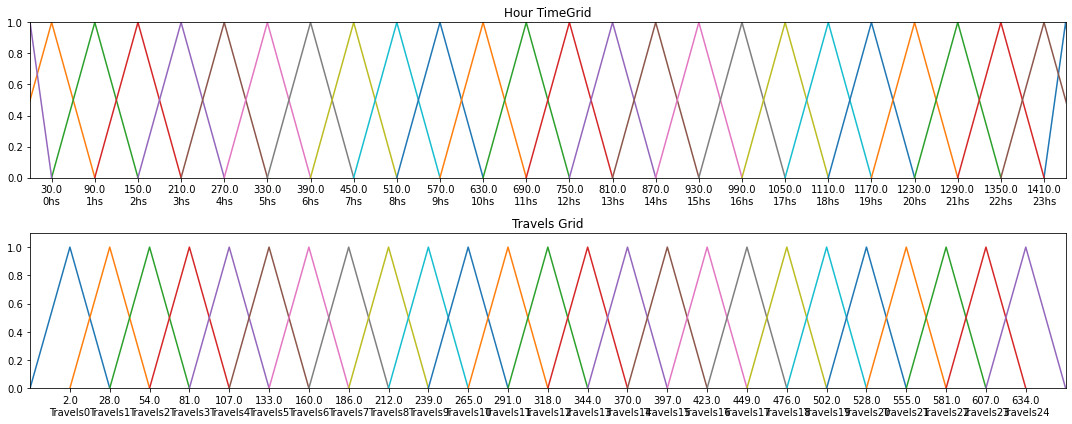

In [17]:
from pyFTS.models.multivariate import common, variable, mvfts, wmvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,6])  

sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k)+'hs' for k in range(0,24)]}

vhour = variable.Variable("Hour", data_label="data", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=c2g_train_new, partitioner_specific=sp)
     
vhour.partitioner.plot(ax[0])                   


c2g_train_new_max = c2g_train_new.copy()
new_row = {'travels':600, 'data':None}
c2g_train_new_max = c2g_train_new_max.append(new_row, ignore_index=True)

vtrav = variable.Variable("Travels", data_label="travels",
                         partitioner=Grid.GridPartitioner, npart=25, 
                         data=c2g_train_new_max) 

vtrav.partitioner.plot(ax[1])

plt.tight_layout()
plt.savefig('fuzzy_partitioner.pdf')  

### Test prediction of the next period in hours.

In [18]:
from tqdm import tqdm

def test_auto_feed(model, X_train, X_test, predict_period=12, path=None):
    """
    Test prediction of the next period in hours.
    In this test each predicted value is included in the training set before the new prediction
    As default it will predict the first 12 hours of the test dataset.
    """
    
    model.fit(X_train)
    
    generator = lambda x : x + pd.to_timedelta(1, unit='h')

    total_predictions = []
    test_values = []
    for i in tqdm(range(1,len(X_test)-predict_period)):
    # for i in tqdm(range(333,len(X_test)-predict_period)):

      y_to_test = X_test.travels.values[i:predict_period+i].copy()
      test_values.append(y_to_test)
      X_to_test = X_test.iloc[i-1:i].copy()
      predictions = model.predict(X_to_test, steps_ahead=predict_period, generators={'data': generator})
      total_predictions.append(predictions)
    
    test_values = np.array(test_values)
    total_predictions = np.array(total_predictions)

    results = (test_values, total_predictions)
    print(test_values.shape)
    print(total_predictions.shape)
    pickle.dump(results, open(path, "wb" ))
    
    return results

## Test prediction of the next 12 hours.

In [19]:
model = wmvfts.WeightedMVFTS()
model.append_variable(vhour)
model.append_variable(vtrav)
model.target_variable = vtrav
results = test_auto_feed(model, c2g_train_new, c2g_test_new, 12, "timeseries-forecast/results/Magazine Results/fuzzy/auto_feed_results.p")

In [ ]:
mvfts.MVFTS
model = mvfts.MVFTS()
model.append_variable(vhour)
model.append_variable(vtrav)
model.target_variable = vtrav
results = test_auto_feed(model, c2g_train_new, c2g_test_new, 12, "timeseries-forecast/results/Magazine Results/fuzzyMVFTS/auto_feed_results.p")


100%|██████████| 338/338 [00:26<00:00, 12.70it/s]

(338, 12)
(338, 12)


## Test prediction of the next week.

In [ ]:
model = wmvfts.WeightedMVFTS()
model.append_variable(vhour)
model.append_variable(vtrav)
model.target_variable = vtrav

results = test_auto_feed(model, c2g_train_new, c2g_test_new, 168, "timeseries-forecast/results/Magazine Results/fuzzy/future_period_results.p")

In [ ]:
mvfts.MVFTS
model = mvfts.MVFTS()
model.append_variable(vhour)
model.append_variable(vtrav)
model.target_variable = vtrav
results = test_auto_feed(model, c2g_train_new, c2g_test_new, 168, "timeseries-forecast/results/Magazine Results/fuzzyMVFTS/future_period_results.p")


100%|██████████| 182/182 [02:55<00:00,  1.04it/s]

(182, 168)
(182, 168)


## Test prediction of the next period in hours with retraining

In [ ]:
from tqdm import tqdm

def test_auto_feed_retraining(model, X_train, X_test, predict_period=12, path=None):
    """
    Test prediction of the next period in hours.
    In this test each predicted value is included in the training set before the new prediction
    As default it will predict the first 12 hours of the test dataset.
    """
    
    model.fit(X_train)

    X_to_train = X_train.copy()
    
    generator = lambda x : x + pd.to_timedelta(1, unit='h')

    total_predictions = []
    test_values = []
    for i in tqdm(range(1,len(X_test)-predict_period)):
    # for i in tqdm(range(333,len(X_test)-predict_period)):

      y_to_test = X_test.travels.values[i:predict_period+i].copy()
      test_values.append(y_to_test)
      X_to_test = X_test.iloc[i-1:i].copy()
      predictions = model.predict(X_to_test, steps_ahead=predict_period, generators={'data': generator})
      total_predictions.append(predictions)

      X_to_train = X_to_train.append(X_to_test, ignore_index=True)
      model.fit(X_to_train)
    
    test_values = np.array(test_values)
    total_predictions = np.array(total_predictions)

    results = (test_values, total_predictions)
    print(test_values.shape)
    print(total_predictions.shape)
    pickle.dump(results, open(path, "wb" ))
    
    return results

## Test prediction of the next 12 hours with retraining.

In [ ]:
model = wmvfts.WeightedMVFTS()
model.append_variable(vhour)
model.append_variable(vtrav)
model.target_variable = vtrav
results = test_auto_feed_retraining(model, c2g_train_new, c2g_test_new, 12, "timeseries-forecast/results/Magazine Results/fuzzy_retraining/auto_feed_results.p")


100%|██████████| 338/338 [16:41<00:00,  2.96s/it]


(338, 12)
(338, 12)


## Test prediction of the next week with retraining.

In [ ]:
model = wmvfts.WeightedMVFTS()
model.append_variable(vhour)
model.append_variable(vtrav)
model.target_variable = vtrav

results = test_auto_feed_retraining(model, c2g_train_new, c2g_test_new, 168, "timeseries-forecast/results/Magazine Results/fuzzy_retraining/future_period_results.p")


100%|██████████| 182/182 [11:07<00:00,  3.67s/it]


(182, 168)
(182, 168)


In [22]:
def read_pickle(path):
    infile = open(path,'rb')
    file = pickle.load(infile)
    infile.close()
    return file

y_hat_12Hrs_fuzzy, y_12Hrs_fuzzy = read_pickle(r'timeseries-forecast/results/Magazine Results/fuzzy/auto_feed_results.p')
y_hat_week_fuzzy, y_week_fuzzy = read_pickle(r'timeseries-forecast/results/Magazine Results/fuzzy/future_period_results.p')

y_hat_12Hrs_fuzzyr, y_12Hrs_fuzzyr = read_pickle(r'timeseries-forecast/results/Magazine Results/fuzzyMVFTS/auto_feed_results.p')
y_hat_week_fuzzyr, y_week_fuzzyr = read_pickle(r'timeseries-forecast/results/Magazine Results/fuzzyMVFTS/future_period_results.p')

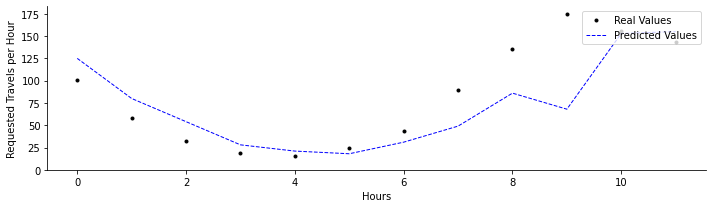

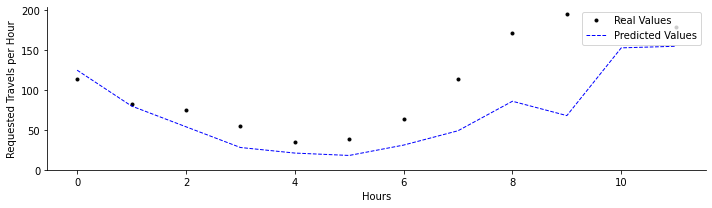

In [66]:
def save_plot(y, y_hat, path):
  x = np.arange(len(y))

  # multiple line plots
  fig, ax = plt.subplots(figsize=(10,3))
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

  plt.plot( x, y, marker='o', label="Real Values", markerfacecolor='black', markersize=3, color='black', linewidth=0)
  plt.plot( x, y_hat, marker='', label="Predicted Values", color='blue', linewidth=1, linestyle='dashed')

  # show legend
  plt.ylim(bottom=0)
  plt.legend(loc="upper right")
  plt.xlabel("Hours")
  plt.ylabel("Requested Travels per Hour")

  # show graph
  fig.tight_layout()
  plt.show()
  fig.savefig(path)

save_plot(y_12Hrs_fuzzy[0], y_hat_12Hrs_fuzzy[0], 'MVFST_12h.pdf')
save_plot(y_12Hrs_fuzzyr[0], y_hat_12Hrs_fuzzyr[0], 'WMVFST_12h.pdf')

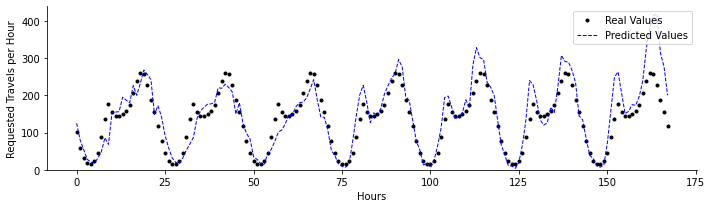

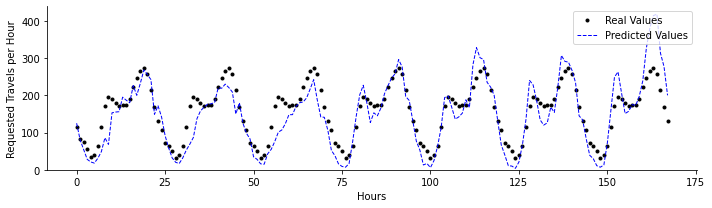

In [67]:
save_plot(y_week_fuzzy[0], y_hat_week_fuzzy[0], 'MVFST_week.pdf')
save_plot(y_week_fuzzyr[0], y_hat_week_fuzzyr[0], 'WMVFST_week.pdf')